# pystencils - LLVM generation
The generation of LLVM code is simliar but not identical as seen with the C++ version. For the generation itself a python module ``llvmlite`` is used. This module provides the necessary support and bindings for LLVM. In order to generate from the AST to llvm, the AST needs to be transformed to support type conversions. This is the biggest difference to the C++ version. C++ doesn't need that since the language itself handles the casts.

In this example a simple weighted Jacobi kernel is generated, so the focus remains on the part of LLVM generation.

In [1]:
import sympy as sp
import numpy as np
import ctypes
from pystencils import Field, Assignment
from pystencils import create_kernel
from pystencils.display_utils import to_dot

sp.init_printing()

The numpy arrays (with inital values) create *Field*s for the update Rule. Later those arrays are used for the computation itself.

In [2]:
src_arr = np.zeros((30, 20))
src_arr[0,:] = 1.0
src_arr[:,0] = 1.0
dst_arr = src_arr.copy()

src_field = Field.create_from_numpy_array('src', src_arr)
dst_field = Field.create_from_numpy_array('dst', dst_arr)

Using the *Field* objects and the additional *Symbol* $\omega$ for the weight the update rule is specified as a *sympy* equation.

In [3]:
omega = sp.symbols("omega")
update_rule = Assignment(dst_field[0,0], omega * (src_field[0,1] + src_field[0,-1] + src_field[1,0] + src_field[-1,0]) / 4
                   + (1.-omega)*src_field[0,0])
update_rule

With this update rule an abstract syntax tree (AST) can be created. This AST can be used to print the LLVM code. The creation follows the same routines as the C++ version does. However at the end there are two more steps. In order to generate LLVM, type casting and pointer arithmetic had to be introduced (which C++ does for you).

In [4]:
ast = create_kernel([update_rule], target='llvm')
print(str(ast))

KernelFunction kernel([<double * RESTRICT fd_dst>, <double * RESTRICT const fd_src>, <double omega>])
	Block for(ctr_0=1; ctr_0<29; ctr_0+=1)
		Block fd_dst_C ← pointer_arithmetic_func(fd_dst, 20*ctr_0)
		fd_src_C ← pointer_arithmetic_func(fd_src, 20*ctr_0)
		fd_src_E ← pointer_arithmetic_func(fd_src, 20*ctr_0 + 20)
		fd_src_W ← pointer_arithmetic_func(fd_src, 20*ctr_0 - 20)
		for(ctr_1=1; ctr_1<19; ctr_1+=1)
			Block fd_dst_C[ctr_1] ← omega*(fd_src_C[ctr_1 + 1] + fd_src_C[ctr_1 - 1] + fd_src_E[ctr_1] + fd_src_W[ctr_1])/4 + (omega*cast_func(-1, double) + 1.0)*fd_src_C[ctr_1]
		
	



It is possible to examine the AST further.

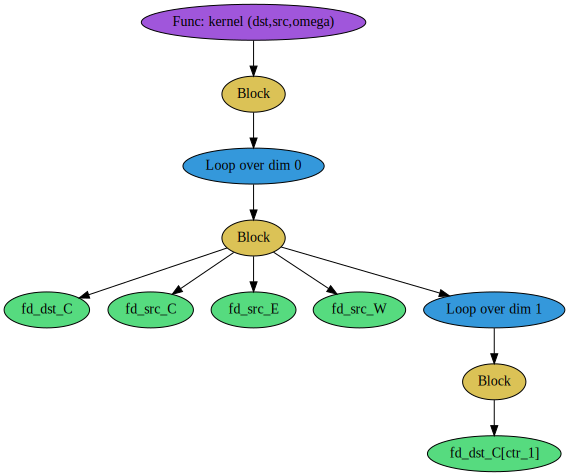

In [5]:
to_dot(ast)

With transformed AST it is now possible to generate and compile the AST into LLVM. Notice that unlike in C++ version, no files are writen to the hard drive (although it is possible).

There are multiple ways how to generate and compile the AST. The most simple one is simillar to the C++ version. Using the ``compile()`` function of the generated AST

You can also manually create a python function with ``make_python_function``.

Another option is obtaining the jit itself with ``generate_and_jit``.
The function ``generate_and_jit`` first generates and the compiles the AST.

If even more controll is needed, it is possible to use the functions ``generateLLVM`` and ``compileLLVM`` to achieve the same. For further controll, instead of calling ``compileLLVM`` the jit object itself can be created and its necessary functions for the compilation have to be run manually (``parse``, (``optimize``,) ``compile``)

In [6]:
kernel = ast.compile()

#kernel = make_python_function(ast)

# Or alternativally
#jit = generate_and_jit(ast)
# Call: jit('kernel', src_arr, dst_arr)

The compiled function(s) can be used now. Either call the function (with arguments, if not given before) or call the jit object with the function's name and its arguments. Here, numpy arrays are automatically adjusted with ctypes.

The functions and arguments can be read as well.

**All of the information the jit object has comes from the module which was parsed. If you parse a second module and don't run the compilation step, the module and the compiled code are not the same anymore, thus leading to false information**

In [7]:
#jit.print_functions()

In [8]:
for i in range(100):
    kernel(src=src_arr, dst=dst_arr, omega=2/3)
    src_arr, dst_arr = dst_arr, src_arr



The output is drawn with matplotlib.

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dst_arr, cmap=cm.jet)
plt.show()

<Figure size 640x480 with 1 Axes>